Starting Loan Default Prediction Analysis...
[22:19:41] Loading data...
[22:19:46] Dropping ID columns: ['Unnamed: 0', 'url', 'id', 'member_id']
[22:19:46] Handling missing values...
[22:19:48] Feature engineering...
[22:19:49] Dataset Information:
Dataset shape: (466285, 52)
Default rate: 11.19%
Missing values per column:
tot_cur_bal                   70276
tot_coll_amt                  70276
total_rev_hi_lim              70276
emp_title                     27588
emp_length                    21008
last_pymnt_d                    376
revol_util                      340
collections_12_mths_ex_med      145
last_credit_pull_d               42
open_acc                         29
dtype: int64
[22:19:50] Splitting data...
[22:19:52] Preprocessing features...
[22:19:55] Processing 12 categorical columns...
[22:19:55] Processing column grade with 7 unique values...
[22:19:55] Processing column sub_grade with 35 unique values...
[22:19:55] Reducing cardinality for sub_grade: 35 -> max 5 catego

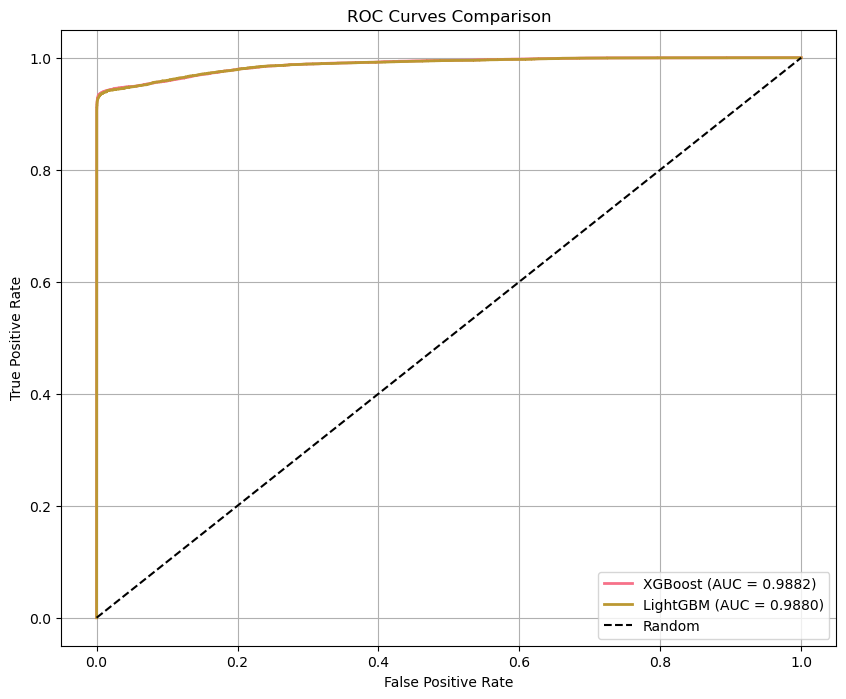

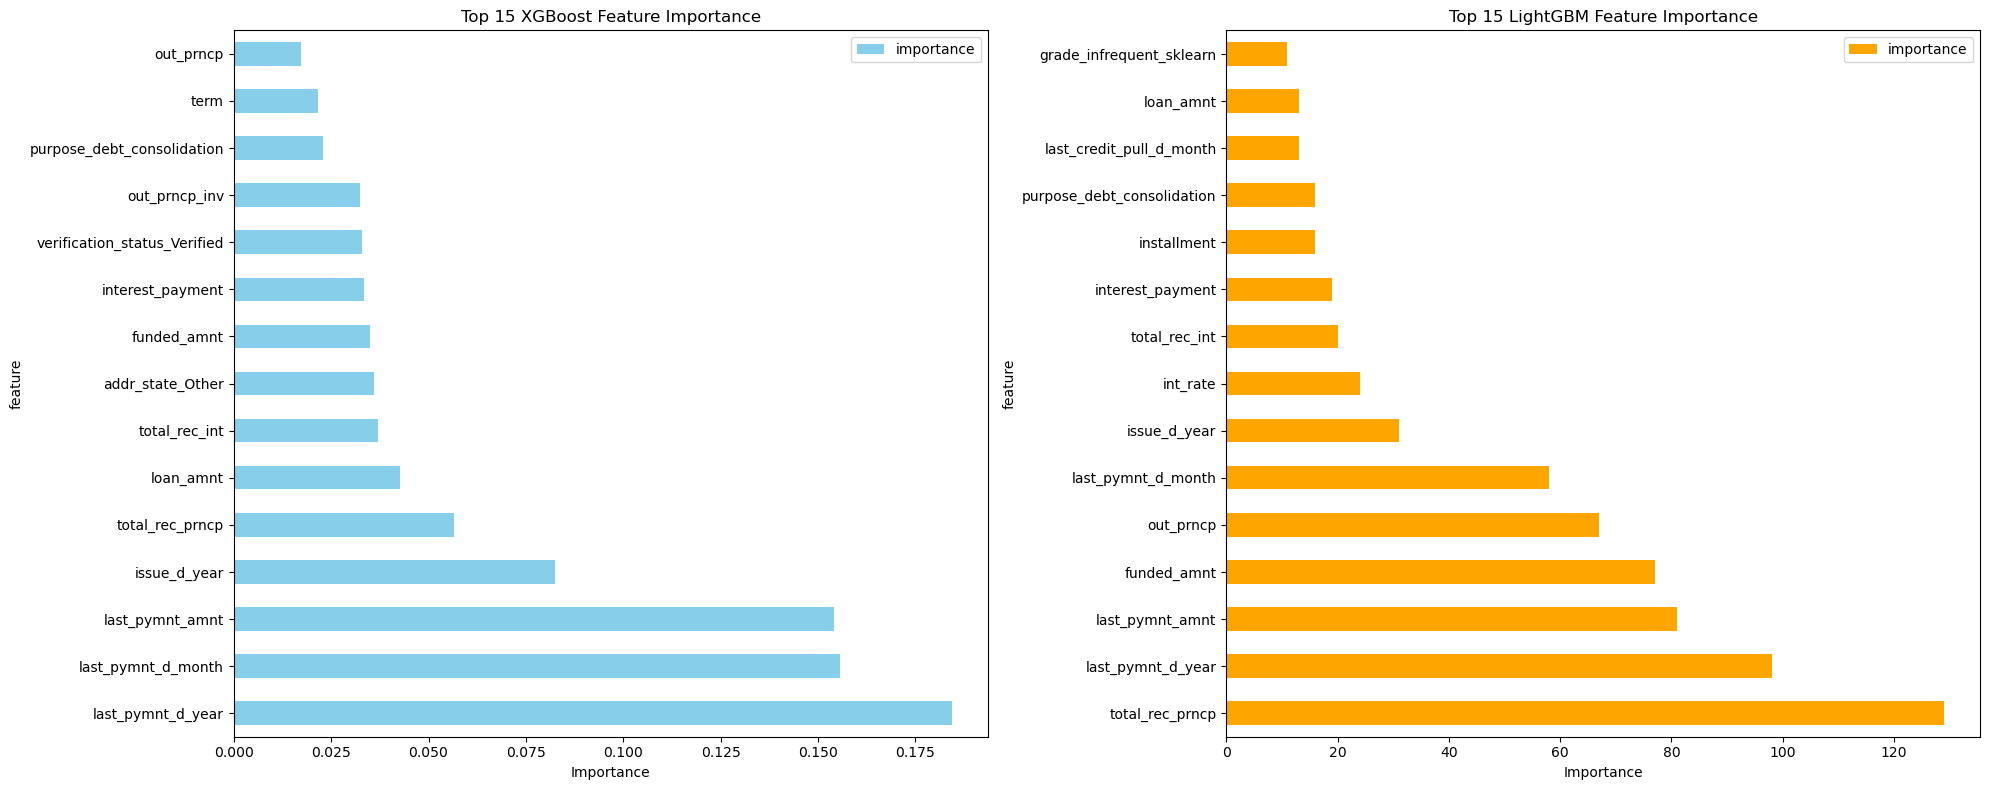


ANALYSIS COMPLETE!
All models have been trained and evaluated successfully.


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import lightgbm as lgb
import time

# Progress tracking
def print_progress(message):
    print(f"[{time.strftime('%H:%M:%S')}] {message}")

# Load dan preprocessing data yang ditingkatkan
def load_and_preprocess_data():
    print_progress("Loading data...")
    # Load data
    df = pd.read_csv(r"C:\Users\ACER\Downloads\loan_data_2007_2014.csv")
    
    # PERBAIKAN: Hapus kolom yang tidak diperlukan termasuk ID columns
    columns_to_drop = ['Unnamed: 0', 'url', 'id', 'member_id']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_cols_to_drop:
        print_progress(f"Dropping ID columns: {existing_cols_to_drop}")
        df.drop(columns=existing_cols_to_drop, inplace=True)
    
    # Define default statuses
    default_statuses = [
        'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
        'Default', 'Does not meet the credit policy. Status:Charged Off'
    ]
    
    # Add is_default column
    df['is_default'] = df['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)
    
    print_progress("Handling missing values...")
    # Handle missing values - keep columns with <= 40% missing (lebih strict)
    missing_percent = df.isnull().mean() * 100
    columns_to_keep = missing_percent[missing_percent <= 40].index
    df = df[columns_to_keep]
    
    # Additional preprocessing
    print_progress("Feature engineering...")
    
    # Create new features
    if 'annual_inc' in df.columns and 'loan_amnt' in df.columns:
        df['loan_to_income_ratio'] = df['loan_amnt'] / (df['annual_inc'] + 1)
    
    if 'int_rate' in df.columns and 'loan_amnt' in df.columns:
        df['interest_payment'] = df['int_rate'] * df['loan_amnt'] / 100
    
    # Remove outliers untuk numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col not in ['is_default']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df

def preprocess_features(X_train, X_test):
    print_progress("Preprocessing features...")
    
    # Process term column
    if 'term' in X_train.columns:
        X_train['term'] = X_train['term'].str.replace(' months', '').astype(int)
        X_test['term'] = X_test['term'].str.replace(' months', '').astype(int)
    
    # Process employment length dengan improvement
    if 'emp_length' in X_train.columns:
        # Convert emp_length to numeric
        emp_length_mapping = {
            '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
            '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
            '10+ years': 10
        }
        
        X_train['emp_length'] = X_train['emp_length'].map(emp_length_mapping)
        X_test['emp_length'] = X_test['emp_length'].map(emp_length_mapping)
        
        # Fill missing with median
        median_emp = X_train['emp_length'].median()
        X_train['emp_length'].fillna(median_emp, inplace=True)
        X_test['emp_length'].fillna(median_emp, inplace=True)
    
    # Process date columns
    col_date = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
    
    for col in col_date:
        if col in X_train.columns:
            # Fill missing values
            mode_value_train = X_train[col].mode()[0] if not X_train[col].mode().empty else 'Jan-2010'
            X_train[col].fillna(mode_value_train, inplace=True)
            X_test[col].fillna(mode_value_train, inplace=True)
            
            # Convert to datetime dan extract features
            X_train[col] = pd.to_datetime(X_train[col], format='%b-%y', errors='coerce')
            X_test[col] = pd.to_datetime(X_test[col], format='%b-%y', errors='coerce')
            
            # Extract year and month
            X_train[f'{col}_year'] = X_train[col].dt.year
            X_train[f'{col}_month'] = X_train[col].dt.month
            X_test[f'{col}_year'] = X_test[col].dt.year
            X_test[f'{col}_month'] = X_test[col].dt.month
            
            # Drop original date column
            X_train.drop(columns=[col], inplace=True)
            X_test.drop(columns=[col], inplace=True)
    
    # Fill numeric columns with median
    X_train_numeric = X_train.select_dtypes(include='number').columns
    for col in X_train_numeric:
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)
    
    # PERBAIKAN UTAMA: Handle categorical columns dengan lebih agresif untuk menghindari memory error
    X_train_categorical = X_train.select_dtypes(include=['object', 'category']).columns
    print_progress(f"Processing {len(X_train_categorical)} categorical columns...")
    
    for col in X_train_categorical:
        print_progress(f"Processing column {col} with {X_train[col].nunique()} unique values...")
        
        # Fill missing values
        mode_value = X_train[col].mode()[0] if not X_train[col].mode().empty else 'Unknown'
        X_train[col].fillna(mode_value, inplace=True)
        X_test[col].fillna(mode_value, inplace=True)
        
        # PERBAIKAN: Sangat agresif dalam mengurangi kardinalitas
        # Hanya keep top 5 categories untuk menghindari memory explosion
        unique_values = X_train[col].nunique()
        
        if unique_values > 10:  # Jika terlalu banyak kategori
            print_progress(f"Reducing cardinality for {col}: {unique_values} -> max 5 categories")
            # Keep only top 4 categories, sisanya jadi 'Other'
            top_categories = X_train[col].value_counts().head(4).index
            X_train[col] = X_train[col].apply(lambda x: x if x in top_categories else 'Other')
            X_test[col] = X_test[col].apply(lambda x: x if x in top_categories else 'Other')
    
    # TAMBAHAN: Drop kolom dengan kardinalitas tinggi yang masih bermasalah
    final_check_cols = X_train.select_dtypes(include=['object', 'category']).columns
    for col in final_check_cols:
        unique_count = X_train[col].nunique()
        if unique_count > 15:  # Threshold lebih ketat
            print_progress(f"WARNING: Dropping high cardinality column {col} with {unique_count} unique values")
            X_train.drop(columns=[col], inplace=True)
            X_test.drop(columns=[col], inplace=True)
    
    return X_train, X_test

def train_models(X_train, X_test, y_train, y_test):
    print_progress("Setting up preprocessing pipeline...")
    
    # Get column names after preprocessing
    num_cols = X_train.select_dtypes(include='number').columns.tolist()
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print_progress(f"Final feature count - Numeric: {len(num_cols)}, Categorical: {len(cat_cols)}")
    
    # Check cardinality of categorical columns one more time
    for col in cat_cols:
        cardinality = X_train[col].nunique()
        print_progress(f"Categorical column {col}: {cardinality} unique values")
    
    # Define preprocessing pipelines dengan parameter yang lebih konservatif
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler()),
    ])
    
    # PERBAIKAN: Gunakan max_categories yang sangat rendah dan sparse=False
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(
            handle_unknown='ignore', 
            sparse_output=False,  # Pastikan False untuk menghindari sparse matrix
            max_categories=5,     # Sangat rendah untuk menghindari memory issue
            drop='if_binary'      # Drop one category for binary features
        ))
    ])
    
    preprocessor = ColumnTransformer([
        ('numeric', numerical_pipeline, num_cols),
        ('categoric', categorical_pipeline, cat_cols)
    ])
    
    # PERBAIKAN: Kurangi sample size untuk SMOTE jika data terlalu besar
    print_progress("Applying SMOTE for data balancing...")
    
    # Check data size
    total_features_estimated = len(num_cols) + sum([X_train[col].nunique() for col in cat_cols]) * 5
    print_progress(f"Estimated total features after encoding: {total_features_estimated}")
    
    # Jika estimasi terlalu besar, sample data terlebih dahulu
    if len(X_train) > 50000 and total_features_estimated > 1000:
        print_progress("Data too large, sampling 50,000 records for training...")
        sample_indices = np.random.choice(X_train.index, size=50000, replace=False)
        X_train_sample = X_train.loc[sample_indices]
        y_train_sample = y_train.loc[sample_indices]
    else:
        X_train_sample = X_train
        y_train_sample = y_train
    
    # SMOTE dengan parameter yang lebih konservatif
    smote = SMOTE(random_state=42, k_neighbors=3)
    
    # XGBoost Pipeline
    print_progress("Training XGBoost model...")
    pipeline_xgb = ImbPipeline([
        ('prep', preprocessor),
        ('smote', smote),
        ('algo', xgb.XGBClassifier(
            random_state=42,
            n_estimators=50,  # Reduced from 100
            max_depth=4,      # Reduced from 6
            learning_rate=0.1,
            eval_metric='logloss',
            n_jobs=1          # Single thread to reduce memory usage
        ))
    ])
    
    pipeline_xgb.fit(X_train_sample, y_train_sample)
    y_pred_xgb = pipeline_xgb.predict(X_test)
    y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
    
    # LightGBM Pipeline
    print_progress("Training LightGBM model...")
    pipeline_lgbm = ImbPipeline([
        ('prep', preprocessor),
        ('smote', smote),
        ('algo', lgb.LGBMClassifier(
            random_state=42,
            n_estimators=50,  # Reduced from 100
            max_depth=4,      # Reduced from 6
            learning_rate=0.1,
            verbose=-1,
            n_jobs=1          # Single thread to reduce memory usage
        ))
    ])
    
    pipeline_lgbm.fit(X_train_sample, y_train_sample)
    y_pred_lgbm = pipeline_lgbm.predict(X_test)
    y_pred_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]
    
    # TAMBAHAN: Mendapatkan feature importance
    print_progress("Extracting feature importance...")
    
    # Get feature names after preprocessing
    feature_names = []
    
    # Numeric features
    feature_names.extend(num_cols)
    
    # Categorical features (after one-hot encoding)
    if cat_cols:
        onehot_encoder = pipeline_xgb.named_steps['prep'].named_transformers_['categoric'].named_steps['onehot']
        cat_feature_names = onehot_encoder.get_feature_names_out(cat_cols)
        feature_names.extend(cat_feature_names)
    
    # XGBoost feature importance
    xgb_importance = pipeline_xgb.named_steps['algo'].feature_importances_
    xgb_feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': xgb_importance
    }).sort_values('importance', ascending=False)
    
    # LightGBM feature importance
    lgbm_importance = pipeline_lgbm.named_steps['algo'].feature_importances_
    lgbm_feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': lgbm_importance
    }).sort_values('importance', ascending=False)
    
    print_progress("Model training completed!")
    
    return {
        'xgb': {
            'model': pipeline_xgb,
            'predictions': y_pred_xgb,
            'probabilities': y_pred_proba_xgb,
            'feature_importance': xgb_feature_importance
        },
        'lgbm': {
            'model': pipeline_lgbm,
            'predictions': y_pred_lgbm,
            'probabilities': y_pred_proba_lgbm,
            'feature_importance': lgbm_feature_importance
        }
    }

# MAIN EXECUTION
print("Starting Loan Default Prediction Analysis...")
print("=" * 50)

# Load data
df = load_and_preprocess_data()

# Display basic information about the dataset
print_progress("Dataset Information:")
print(f"Dataset shape: {df.shape}")
print(f"Default rate: {df['is_default'].mean():.2%}")
print(f"Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# Split data
print_progress("Splitting data...")
X = df.drop(columns=['is_default', 'loan_status'])
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess features
X_train, X_test = preprocess_features(X_train.copy(), X_test.copy())

# Train models
models = train_models(X_train, X_test, y_train, y_test)

# Calculate metrics for both models
print_progress("Calculating metrics...")
metrics = {}
for model_name, model_data in models.items():
    roc_auc = roc_auc_score(y_test, model_data['probabilities'])
    accuracy = accuracy_score(y_test, model_data['predictions'])
    conf_matrix = confusion_matrix(y_test, model_data['predictions'])
    fpr, tpr, _ = roc_curve(y_test, model_data['probabilities'])
    class_report = classification_report(y_test, model_data['predictions'])
    
    metrics[model_name] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'classification_report': class_report
    }
    
    print(f"{model_name.upper()} - ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

print_progress("Analysis completed!")

# Display results
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

for model_name in ['xgb', 'lgbm']:
    print(f"\n{model_name.upper()} Model Results:")
    print(f"ROC AUC Score: {metrics[model_name]['roc_auc']:.4f}")
    print(f"Accuracy: {metrics[model_name]['accuracy']:.4f}")
    print(f"Confusion Matrix:")
    print(metrics[model_name]['conf_matrix'])
    print(f"\nClassification Report:")
    print(metrics[model_name]['classification_report'])
    
    print(f"\nTop 10 Feature Importance ({model_name.upper()}):")
    print(models[model_name]['feature_importance'].head(10))

# Create some basic visualizations
print_progress("Creating visualizations...")

# ROC Curve Comparison
plt.figure(figsize=(10, 8))
plt.plot(metrics['xgb']['fpr'], metrics['xgb']['tpr'], 
         label=f'XGBoost (AUC = {metrics["xgb"]["roc_auc"]:.4f})', linewidth=2)
plt.plot(metrics['lgbm']['fpr'], metrics['lgbm']['tpr'], 
         label=f'LightGBM (AUC = {metrics["lgbm"]["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# XGBoost Feature Importance
models['xgb']['feature_importance'].head(15).plot(
    x='feature', y='importance', kind='barh', ax=ax1, color='skyblue'
)
ax1.set_title('Top 15 XGBoost Feature Importance')
ax1.set_xlabel('Importance')

# LightGBM Feature Importance
models['lgbm']['feature_importance'].head(15).plot(
    x='feature', y='importance', kind='barh', ax=ax2, color='orange'
)
ax2.set_title('Top 15 LightGBM Feature Importance')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("All models have been trained and evaluated successfully.")
print("="*50)